# Patos

In [30]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs\Patos\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas
        renomear = {
            'DATA (YYYY-MM-DD)': 'data',
            'HORA (UTC)': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Substitui TODAS as variações de -9999 por NaN (strings e números) ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace(-9999, np.nan)
        df = df.replace(-9999.0, np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # --- Segurança extra: garante que ainda não exista -9999 em float ---
        df.loc[df['temp'] == -9999, 'temp'] = np.nan
        df.loc[df['umidade'] == -9999, 'umidade'] = np.nan
        df.loc[df['pressao'] == -9999, 'pressao'] = np.nan

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [
            f"{var}_{estat}"
            for var, estat in agrupado.columns
        ]

        # Reset index para voltar a ter 'data' como coluna
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_patos1 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_patos1['data'] = pd.to_datetime(df_patos1['data'], errors='coerce')
df_patos1.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_patos1 = df_patos1[[col for col in colunas_final if col in df_patos1.columns]]

# Exibe amostra
print(df_patos1.head(10))


           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
4018 2007-07-21      20.0      31.8  26.333333         36.0         82.0   
4019 2007-07-22      22.6      27.6  24.883333         49.0         93.0   
4020 2007-07-23      22.5      30.1  25.441667         44.0         88.0   
4021 2007-07-24      20.1      33.3  26.508333         28.0         92.0   
4022 2007-07-25      21.2      32.4  26.820833         31.0         79.0   
4023 2007-07-26      21.5      34.1  27.350000         30.0         84.0   
4024 2007-07-27      22.9      32.3  26.912500         33.0         78.0   
4025 2007-07-28      20.9      32.7  26.473913         29.0         66.0   
4026 2007-07-29      21.1      33.1  26.720833         29.0         77.0   
4027 2007-07-30      21.6      33.9  27.291667         18.0         69.0   

      umidade_mean  pressao_min  pressao_max  pressao_mean  
4018     53.041667        982.8        987.0    984.912500  
4019     72.000000        981.8        98

In [31]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs2\Patos\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'Data',
    'HORA UTC',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas (ajuste no nome exato de 'HORA UTC')
        renomear = {
            'Data': 'data',
            'HORA UTC': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Trata coluna 'hora' no formato "0000 UTC" ---
        if 'hora' in df.columns:
            df['hora'] = (
                df['hora']
                .astype(str)
                .str.extract(r'(\d{4})')[0]  # extrai os 4 dígitos
                .apply(lambda x: f"{x[:2]}:{x[2:]}" if pd.notna(x) and len(x) == 4 else np.nan)
            )

        # --- Substitui -9999 e células vazias por NaN ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace('', np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [f"{var}_{estat}" for var, estat in agrupado.columns]
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_patos2 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_patos2['data'] = pd.to_datetime(df_patos2['data'], errors='coerce')
df_patos2.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_patos2 = df_patos2[[col for col in colunas_final if col in df_patos2.columns]]

# Exibe amostra
print(df_patos2.head(10))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2019-01-01      24.0      37.4  30.437500         10.0         57.0   
1 2019-01-02      25.4      37.9  30.637500         10.0         52.0   
2 2019-01-03      23.6      36.4  29.766667         10.0         56.0   
3 2019-01-04      23.6      36.3  28.800000         11.0         70.0   
4 2019-01-05      23.0      35.6  27.958333         15.0         80.0   
5 2019-01-06      24.1      33.2  27.820833         18.0         77.0   
6 2019-01-07      24.4      34.0  28.116667         21.0         62.0   
7 2019-01-08      23.0      33.4  26.829167         23.0         84.0   
8 2019-01-09      22.2      33.8  26.879167         22.0         89.0   
9 2019-01-10      23.4      34.0  28.300000         14.0         61.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     34.619048        980.5        985.5    982.979167  
1     32.761905        981.0        985.5    983.716667  
2     29.708333       

In [32]:
# Junta os dois datasets
df_patos = pd.concat([df_patos1, df_patos2], ignore_index=True)

# Converte 'data' para datetime (caso ainda não esteja)
df_patos['data'] = pd.to_datetime(df_patos['data'], errors='coerce')

# Ordena por data
df_patos.sort_values(by='data', inplace=True)

# Exibe amostra
print(df_patos.head())
print(df_patos.tail())


# Cria colunas de ano e mês
df_patos['ano'] = df_patos['data'].dt.year
df_patos['mes'] = df_patos['data'].dt.month

# Calcula a média mensal
patos_media_mensal = (
    df_patos
    .groupby(['ano', 'mes'], as_index=False)
    .agg({
        'temp_min': 'mean',
        'temp_max': 'mean',
        'temp_mean': 'mean',
        'umidade_min': 'mean',
        'umidade_max': 'mean',
        'umidade_mean': 'mean',
        'pressao_min': 'mean',
        'pressao_max': 'mean',
        'pressao_mean': 'mean'
    })
)

# Cria coluna de data representando o mês
patos_media_mensal['ano_mes'] = pd.to_datetime(
    patos_media_mensal['ano'].astype(str) + '-' +
    patos_media_mensal['mes'].astype(str) + '-01'
)

# Reorganiza colunas
patos_media_mensal = patos_media_mensal[
    ['ano_mes', 'temp_min', 'temp_max', 'temp_mean',
     'umidade_min', 'umidade_max', 'umidade_mean',
     'pressao_min', 'pressao_max', 'pressao_mean']
]

# Exibe amostra
print(patos_media_mensal.head(12))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2007-07-21      20.0      31.8  26.333333         36.0         82.0   
1 2007-07-22      22.6      27.6  24.883333         49.0         93.0   
2 2007-07-23      22.5      30.1  25.441667         44.0         88.0   
3 2007-07-24      20.1      33.3  26.508333         28.0         92.0   
4 2007-07-25      21.2      32.4  26.820833         31.0         79.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     53.041667        982.8        987.0    984.912500  
1     72.000000        981.8        985.6    983.812500  
2     68.666667        981.7        985.6    983.870833  
3     58.791667        981.5        986.4    984.087500  
4     55.083333        981.5        985.9    984.029167  
           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
6369 2024-12-27      22.2      37.4  29.470833         27.0         75.0   
6370 2024-12-28      25.7      37.0  30.973913         30.0  

# Areia


In [33]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs\Areia\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas
        renomear = {
            'DATA (YYYY-MM-DD)': 'data',
            'HORA (UTC)': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Substitui TODAS as variações de -9999 por NaN (strings e números) ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace(-9999, np.nan)
        df = df.replace(-9999.0, np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # --- Segurança extra: garante que ainda não exista -9999 em float ---
        df.loc[df['temp'] == -9999, 'temp'] = np.nan
        df.loc[df['umidade'] == -9999, 'umidade'] = np.nan
        df.loc[df['pressao'] == -9999, 'pressao'] = np.nan

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [
            f"{var}_{estat}"
            for var, estat in agrupado.columns
        ]

        # Reset index para voltar a ter 'data' como coluna
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_areia1 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_areia1['data'] = pd.to_datetime(df_areia1['data'], errors='coerce')
df_areia1.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_areia1 = df_areia1[[col for col in colunas_final if col in df_areia1.columns]]

# Exibe amostra
print(df_areia1.head(10))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2007-01-01      20.5      28.5  23.637500         57.0        100.0   
1 2007-01-02      21.2      26.3  22.891667         68.0        100.0   
2 2007-01-03      19.9      28.0  22.779167         48.0        100.0   
3 2007-01-04      19.7      27.1  22.495833         68.0        100.0   
4 2007-01-05      20.8      27.6  23.287500         58.0        100.0   
5 2007-01-06      20.5      27.0  22.858333         66.0        100.0   
6 2007-01-07      19.9      28.1  23.233333         57.0        100.0   
7 2007-01-08      20.9      26.9  23.000000         58.0        100.0   
8 2007-01-09      20.8      27.8  23.408333         65.0        100.0   
9 2007-01-10      20.7      28.4  23.541667         56.0        100.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     82.750000        946.8        950.2    948.587500  
1     88.173913        947.6        950.5    949.029167  
2     74.153846       

In [34]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs2\Areia\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'Data',
    'HORA UTC',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas (ajuste no nome exato de 'HORA UTC')
        renomear = {
            'Data': 'data',
            'HORA UTC': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Trata coluna 'hora' no formato "0000 UTC" ---
        if 'hora' in df.columns:
            df['hora'] = (
                df['hora']
                .astype(str)
                .str.extract(r'(\d{4})')[0]  # extrai os 4 dígitos
                .apply(lambda x: f"{x[:2]}:{x[2:]}" if pd.notna(x) and len(x) == 4 else np.nan)
            )

        # --- Substitui -9999 e células vazias por NaN ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace('', np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [f"{var}_{estat}" for var, estat in agrupado.columns]
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_areia2 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_areia2['data'] = pd.to_datetime(df_areia2['data'], errors='coerce')
df_areia2.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_areia2 = df_areia2[[col for col in colunas_final if col in df_areia2.columns]]

# Exibe amostra
print(df_areia2.head(10))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2019-01-01      21.4      30.0  24.550000         49.0         94.0   
1 2019-01-02      21.6      30.3  24.700000         43.0         94.0   
2 2019-01-03      20.7      30.2  24.329167         44.0         94.0   
3 2019-01-04      20.6      30.3  24.287500         46.0         95.0   
4 2019-01-05      21.6      28.9  24.125000         52.0         93.0   
5 2019-01-06      21.2      28.6  24.016667         48.0         95.0   
6 2019-01-07      20.7      28.4  23.370833         56.0         94.0   
7 2019-01-08      20.5      27.8  23.062500         57.0         95.0   
8 2019-01-09      20.6      27.3  22.979167         57.0         96.0   
9 2019-01-10      20.7      29.7  24.000000         40.0         95.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     77.125000        947.8        951.0    949.225000  
1     73.250000        948.6        951.4    950.012500  
2     74.125000       

In [35]:
# Junta os dois datasets
df_areia = pd.concat([df_areia1, df_areia2], ignore_index=True)

# Converte 'data' para datetime (caso ainda não esteja)
df_areia['data'] = pd.to_datetime(df_areia['data'], errors='coerce')

# Ordena por data
df_areia.sort_values(by='data', inplace=True)

# Exibe amostra
print(df_areia.head())
print(df_areia.tail())


# Cria colunas de ano e mês
df_areia['ano'] = df_areia['data'].dt.year
df_areia['mes'] = df_areia['data'].dt.month

# Calcula a média mensal
areia_media_mensal = (
    df_areia
    .groupby(['ano', 'mes'], as_index=False)
    .agg({
        'temp_min': 'mean',
        'temp_max': 'mean',
        'temp_mean': 'mean',
        'umidade_min': 'mean',
        'umidade_max': 'mean',
        'umidade_mean': 'mean',
        'pressao_min': 'mean',
        'pressao_max': 'mean',
        'pressao_mean': 'mean'
    })
)

# Cria coluna de data representando o mês
areia_media_mensal['ano_mes'] = pd.to_datetime(
    areia_media_mensal['ano'].astype(str) + '-' +
    areia_media_mensal['mes'].astype(str) + '-01'
)

# Reorganiza colunas
areia_media_mensal = areia_media_mensal[
    ['ano_mes', 'temp_min', 'temp_max', 'temp_mean',
     'umidade_min', 'umidade_max', 'umidade_mean',
     'pressao_min', 'pressao_max', 'pressao_mean']
]

# Exibe amostra
print(areia_media_mensal.head(12))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2007-01-01      20.5      28.5  23.637500         57.0        100.0   
1 2007-01-02      21.2      26.3  22.891667         68.0        100.0   
2 2007-01-03      19.9      28.0  22.779167         48.0        100.0   
3 2007-01-04      19.7      27.1  22.495833         68.0        100.0   
4 2007-01-05      20.8      27.6  23.287500         58.0        100.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     82.750000        946.8        950.2    948.587500  
1     88.173913        947.6        950.5    949.029167  
2     74.153846        946.9        950.0    948.491667  
3     85.000000        946.5        949.2    947.816667  
4     81.529412        945.6        948.8    947.270833  
           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
6570 2024-12-27      20.2      28.7  23.579167         54.0         95.0   
6571 2024-12-28      21.3      28.8  23.766667         57.0  

# João Pessoa

In [36]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs\Joao Pessoa\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas
        renomear = {
            'DATA (YYYY-MM-DD)': 'data',
            'HORA (UTC)': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Substitui TODAS as variações de -9999 por NaN (strings e números) ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace(-9999, np.nan)
        df = df.replace(-9999.0, np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # --- Segurança extra: garante que ainda não exista -9999 em float ---
        df.loc[df['temp'] == -9999, 'temp'] = np.nan
        df.loc[df['umidade'] == -9999, 'umidade'] = np.nan
        df.loc[df['pressao'] == -9999, 'pressao'] = np.nan

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [
            f"{var}_{estat}"
            for var, estat in agrupado.columns
        ]

        # Reset index para voltar a ter 'data' como coluna
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_jampa1 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_jampa1['data'] = pd.to_datetime(df_jampa1['data'], errors='coerce')
df_jampa1.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_jampa1 = df_jampa1[[col for col in colunas_final if col in df_jampa1.columns]]

# Exibe amostra
print(df_jampa1.head(10))


Erro ao ler csvs\Joao Pessoa\INMET_NE_PB_A320_JOAO PESSOA_01-01-2012_A_31-12-2012.CSV: 'temp'
           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
3652 2007-07-21      24.3      26.4  25.060000         70.0         84.0   
3653 2007-07-22      21.8      26.2  23.345833         74.0         95.0   
3654 2007-07-23      21.4      27.9  24.312500         60.0         94.0   
3655 2007-07-24      21.0      28.1  24.439130         60.0         93.0   
3656 2007-07-25      21.0      28.2  25.045833         62.0         95.0   
3657 2007-07-26      22.3      27.8  24.620833         71.0         94.0   
3658 2007-07-27      22.1      27.8  24.954167         62.0         96.0   
3659 2007-07-28      20.1      27.8  23.957143         59.0         94.0   
3660 2007-07-29      21.5      27.9  24.245833         61.0         94.0   
3661 2007-07-30      21.8      27.7  24.316667         59.0         89.0   

      umidade_mean  pressao_min  pressao_max  pressao_mean  
3652    

In [37]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs2\Joao Pessoa\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'Data',
    'HORA UTC',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas (ajuste no nome exato de 'HORA UTC')
        renomear = {
            'Data': 'data',
            'HORA UTC': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Trata coluna 'hora' no formato "0000 UTC" ---
        if 'hora' in df.columns:
            df['hora'] = (
                df['hora']
                .astype(str)
                .str.extract(r'(\d{4})')[0]  # extrai os 4 dígitos
                .apply(lambda x: f"{x[:2]}:{x[2:]}" if pd.notna(x) and len(x) == 4 else np.nan)
            )

        # --- Substitui -9999 e células vazias por NaN ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace('', np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [f"{var}_{estat}" for var, estat in agrupado.columns]
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_jampa2 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_jampa2['data'] = pd.to_datetime(df_jampa2['data'], errors='coerce')
df_jampa2.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_jampa2 = df_jampa2[[col for col in colunas_final if col in df_jampa2.columns]]

# Exibe amostra
print(df_jampa2.head(10))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2019-01-01      25.0      30.8  27.358333         60.0         88.0   
1 2019-01-02      26.2      30.4  27.762500         58.0         82.0   
2 2019-01-03      25.7      30.8  27.754167         54.0         77.0   
3 2019-01-04      25.7      31.1  27.825000         57.0         80.0   
4 2019-01-05      26.5      31.1  27.904167         60.0         79.0   
5 2019-01-06      25.5      30.9  27.700000         55.0         80.0   
6 2019-01-07      23.2      31.0  27.058333         57.0         90.0   
7 2019-01-08      26.5      31.5  28.012500         55.0         76.0   
8 2019-01-09      26.5      31.8  28.216667         53.0         79.0   
9 2019-01-10      26.2      31.9  28.166667         53.0         76.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     75.625000       1008.6       1012.1   1010.358333  
1     72.000000       1010.3       1012.5   1011.333333  
2     67.208333       

In [38]:
# Junta os dois datasets
df_jampa = pd.concat([df_jampa1, df_jampa2], ignore_index=True)

# Converte 'data' para datetime (caso ainda não esteja)
df_jampa['data'] = pd.to_datetime(df_jampa['data'], errors='coerce')

# Ordena por data
df_jampa.sort_values(by='data', inplace=True)

# Exibe amostra
print(df_jampa.head())
print(df_jampa.tail())


# Cria colunas de ano e mês
df_jampa['ano'] = df_jampa['data'].dt.year
df_jampa['mes'] = df_jampa['data'].dt.month

# Calcula a média mensal
jampa_media_mensal = (
    df_jampa
    .groupby(['ano', 'mes'], as_index=False)
    .agg({
        'temp_min': 'mean',
        'temp_max': 'mean',
        'temp_mean': 'mean',
        'umidade_min': 'mean',
        'umidade_max': 'mean',
        'umidade_mean': 'mean',
        'pressao_min': 'mean',
        'pressao_max': 'mean',
        'pressao_mean': 'mean'
    })
)

# Cria coluna de data representando o mês
jampa_media_mensal['ano_mes'] = pd.to_datetime(
    jampa_media_mensal['ano'].astype(str) + '-' +
    jampa_media_mensal['mes'].astype(str) + '-01'
)

# Reorganiza colunas
jampa_media_mensal = jampa_media_mensal[
    ['ano_mes', 'temp_min', 'temp_max', 'temp_mean',
     'umidade_min', 'umidade_max', 'umidade_mean',
     'pressao_min', 'pressao_max', 'pressao_mean']
]

# Exibe amostra
print(jampa_media_mensal.head(12))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2007-07-21      24.3      26.4  25.060000         70.0         84.0   
1 2007-07-22      21.8      26.2  23.345833         74.0         95.0   
2 2007-07-23      21.4      27.9  24.312500         60.0         94.0   
3 2007-07-24      21.0      28.1  24.439130         60.0         93.0   
4 2007-07-25      21.0      28.2  25.045833         62.0         95.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     79.000000       1009.3       1010.3   1009.700000  
1     88.666667       1007.7       1010.9   1009.229167  
2     81.666667       1007.9       1010.2   1009.187500  
3     79.739130       1009.1       1011.4   1010.021739  
4     79.083333       1008.4       1011.6   1009.966667  
           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
6003 2024-12-27      25.0      31.4  27.842857         55.0         82.0   
6004 2024-12-28      24.9      31.5  27.754545         61.0  

# Campina Grande

In [5]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs\Campina\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas
        renomear = {
            'DATA (YYYY-MM-DD)': 'data',
            'HORA (UTC)': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Substitui TODAS as variações de -9999 por NaN (strings e números) ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace(-9999, np.nan)
        df = df.replace(-9999.0, np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # --- Segurança extra: garante que ainda não exista -9999 em float ---
        df.loc[df['temp'] == -9999, 'temp'] = np.nan
        df.loc[df['umidade'] == -9999, 'umidade'] = np.nan
        df.loc[df['pressao'] == -9999, 'pressao'] = np.nan

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [
            f"{var}_{estat}"
            for var, estat in agrupado.columns
        ]

        # Reset index para voltar a ter 'data' como coluna
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_campina1 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_campina1['data'] = pd.to_datetime(df_campina1['data'], errors='coerce')
df_campina1.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_campina1 = df_campina1[[col for col in colunas_final if col in df_campina1.columns]]

# Exibe amostra
print(df_campina1.head(10))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2007-01-01      24.2      31.0  27.500000         42.0         77.0   
1 2007-01-02      23.8      25.4  24.600000         75.0         84.0   
2 2007-01-03      23.6      29.7  27.033333         45.0         78.0   
3 2007-01-04      23.0      25.6  24.300000         81.0         89.0   
4 2007-01-05      24.4      28.8  26.700000         53.0         79.0   
5 2007-01-06      25.3      28.5  26.900000         61.0         75.0   
6 2007-01-07      24.9      29.4  27.466667         49.0         71.0   
7 2007-01-08      26.3      28.8  27.550000         51.0         67.0   
8 2007-01-09      24.8      30.3  27.600000         51.0         80.0   
9 2007-01-10      24.8      29.8  27.300000         48.0         79.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     61.666667        951.6        953.5    952.800000  
1     79.500000        952.8        954.0    953.400000  
2     61.000000       

In [ ]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs\Campina\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas
        renomear = {
            'DATA (YYYY-MM-DD)': 'data',
            'HORA (UTC)': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Substitui TODAS as variações de -9999 por NaN (strings e números) ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace(-9999, np.nan)
        df = df.replace(-9999.0, np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # --- Segurança extra: garante que ainda não exista -9999 em float ---
        df.loc[df['temp'] == -9999, 'temp'] = np.nan
        df.loc[df['umidade'] == -9999, 'umidade'] = np.nan
        df.loc[df['pressao'] == -9999, 'pressao'] = np.nan

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [
            f"{var}_{estat}"
            for var, estat in agrupado.columns
        ]

        # Reset index para voltar a ter 'data' como coluna
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_campina1 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_campina1['data'] = pd.to_datetime(df_campina1['data'], errors='coerce')
df_campina1.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_campina1 = df_campina1[[col for col in colunas_final if col in df_campina1.columns]]

# Exibe amostra
print(df_campina1.head(10))


In [7]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs2\Campina\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'Data',
    'HORA UTC',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas (ajuste no nome exato de 'HORA UTC')
        renomear = {
            'Data': 'data',
            'HORA UTC': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Trata coluna 'hora' no formato "0000 UTC" ---
        if 'hora' in df.columns:
            df['hora'] = (
                df['hora']
                .astype(str)
                .str.extract(r'(\d{4})')[0]  # extrai os 4 dígitos
                .apply(lambda x: f"{x[:2]}:{x[2:]}" if pd.notna(x) and len(x) == 4 else np.nan)
            )

        # --- Substitui -9999 e células vazias por NaN ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace('', np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [f"{var}_{estat}" for var, estat in agrupado.columns]
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_campina2 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_campina2['data'] = pd.to_datetime(df_campina2['data'], errors='coerce')
df_campina2.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_campina2 = df_campina2[[col for col in colunas_final if col in df_campina2.columns]]

# Exibe amostra
print(df_campina2.head(10))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2019-01-01      21.9      30.5  25.383333         47.0         95.0   
1 2019-01-02      22.1      30.7  25.637500         40.0         93.0   
2 2019-01-03      20.8      31.3  25.316667         41.0         92.0   
3 2019-01-04      21.1      31.0  25.320833         44.0         90.0   
4 2019-01-05      22.0      30.4  25.254167         47.0         91.0   
5 2019-01-06      21.9      30.0  25.162500         46.0         92.0   
6 2019-01-07      21.4      30.5  24.312500         49.0         90.0   
7 2019-01-08      21.0      29.5  24.245833         55.0         94.0   
8 2019-01-09      21.6      29.5  24.287500         51.0         96.0   
9 2019-01-10      21.0      30.9  24.904167         40.0         92.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     73.708333        951.4        954.7    952.883333  
1     69.166667        952.1        955.1    953.658333  
2     69.375000       

In [8]:
# Junta os dois datasets
df_campina = pd.concat([df_campina1, df_campina2], ignore_index=True)

# Converte 'data' para datetime (caso ainda não esteja)
df_campina['data'] = pd.to_datetime(df_campina['data'], errors='coerce')

# Ordena por data
df_campina.sort_values(by='data', inplace=True)

# Exibe amostra
print(df_campina.head())
print(df_campina.tail())


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2007-01-01      24.2      31.0  27.500000         42.0         77.0   
1 2007-01-02      23.8      25.4  24.600000         75.0         84.0   
2 2007-01-03      23.6      29.7  27.033333         45.0         78.0   
3 2007-01-04      23.0      25.6  24.300000         81.0         89.0   
4 2007-01-05      24.4      28.8  26.700000         53.0         79.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     61.666667        951.6        953.5    952.800000  
1     79.500000        952.8        954.0    953.400000  
2     61.000000        950.8        953.1    952.133333  
3     85.000000        951.0        952.2    951.600000  
4     66.666667        949.9        951.9    950.966667  
           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
6570 2024-12-27      20.7      30.8  25.095833         49.0         94.0   
6571 2024-12-28      22.1      31.2  25.629167         53.0  

In [9]:
# Cria colunas de ano e mês
df_campina['ano'] = df_campina['data'].dt.year
df_campina['mes'] = df_campina['data'].dt.month

# Calcula a média mensal
campina_media_mensal = (
    df_campina
    .groupby(['ano', 'mes'], as_index=False)
    .agg({
        'temp_min': 'mean',
        'temp_max': 'mean',
        'temp_mean': 'mean',
        'umidade_min': 'mean',
        'umidade_max': 'mean',
        'umidade_mean': 'mean',
        'pressao_min': 'mean',
        'pressao_max': 'mean',
        'pressao_mean': 'mean'
    })
)

# Cria coluna de data representando o mês
campina_media_mensal['ano_mes'] = pd.to_datetime(
    campina_media_mensal['ano'].astype(str) + '-' +
    campina_media_mensal['mes'].astype(str) + '-01'
)

# Reorganiza colunas
campina_media_mensal = campina_media_mensal[
    ['ano_mes', 'temp_min', 'temp_max', 'temp_mean',
     'umidade_min', 'umidade_max', 'umidade_mean',
     'pressao_min', 'pressao_max', 'pressao_mean']
]

# Exibe amostra
print(campina_media_mensal.head(12))


      ano_mes   temp_min   temp_max  temp_mean  umidade_min  umidade_max  \
0  2007-01-01  26.419355  30.067742  28.284409    46.161290    65.064516   
1  2007-02-01  26.582143  30.017857  28.330952    48.607143    65.892857   
2  2007-03-01  25.764516  28.406452  27.175806    56.354839    70.612903   
3  2007-04-01  25.631034  29.034483  27.480460    53.310345    70.344828   
4  2007-05-01  22.864516  27.306452  25.037710    62.064516    83.709677   
5  2007-06-01  19.460000  25.556667  21.663267    67.500000    95.566667   
6  2007-07-01  18.790323  25.541935  21.496798    63.096774    95.193548   
7  2007-08-01  18.532258  25.300000  21.088184    61.225806    95.161290   
8  2007-09-01  18.700000  26.620000  21.804444    53.700000    93.000000   
9  2007-10-01  19.577419  28.877419  23.200806    43.645161    91.387097   
10 2007-11-01  20.300000  30.226667  24.105278    39.133333    91.566667   
11 2007-12-01  20.735484  30.135484  24.293280    41.774194    91.516129   

    umidade

# Cabaceiras

In [10]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs\Cabaceiras\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas
        renomear = {
            'DATA (YYYY-MM-DD)': 'data',
            'HORA (UTC)': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Substitui TODAS as variações de -9999 por NaN (strings e números) ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace(-9999, np.nan)
        df = df.replace(-9999.0, np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # --- Segurança extra: garante que ainda não exista -9999 em float ---
        df.loc[df['temp'] == -9999, 'temp'] = np.nan
        df.loc[df['umidade'] == -9999, 'umidade'] = np.nan
        df.loc[df['pressao'] == -9999, 'pressao'] = np.nan

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [
            f"{var}_{estat}"
            for var, estat in agrupado.columns
        ]

        # Reset index para voltar a ter 'data' como coluna
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_cabaceiras1 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_cabaceiras1['data'] = pd.to_datetime(df_cabaceiras1['data'], errors='coerce')
df_cabaceiras1.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_cabaceiras1 = df_cabaceiras1[[col for col in colunas_final if col in df_cabaceiras1.columns]]

# Exibe amostra
print(df_cabaceiras1.head(10))


           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
3652 2008-02-28       NaN       NaN        NaN          NaN          NaN   
3653 2008-02-29      26.9      32.6  30.255556         38.0         64.0   
3654 2008-03-01      22.9      33.5  27.529167         32.0         91.0   
3655 2008-03-02      21.0      33.8  26.954167         30.0         94.0   
3656 2008-03-03      20.8      34.6  27.100000         27.0         94.0   
3657 2008-03-04      21.7      35.0  27.666667         29.0         91.0   
3658 2008-03-05      23.4      34.6  28.391667         26.0         87.0   
3659 2008-03-06      22.0      34.1  27.750000         26.0         89.0   
3660 2008-03-07      22.3      34.7  27.779167         23.0         88.0   
3661 2008-03-08      23.9      32.9  27.279167         30.0         80.0   

      umidade_mean  pressao_min  pressao_max  pressao_mean  
3652           NaN          NaN          NaN           NaN  
3653     49.000000        962.5        96

In [11]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs2\cabaceiras\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'Data',
    'HORA UTC',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas (ajuste no nome exato de 'HORA UTC')
        renomear = {
            'Data': 'data',
            'HORA UTC': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Trata coluna 'hora' no formato "0000 UTC" ---
        if 'hora' in df.columns:
            df['hora'] = (
                df['hora']
                .astype(str)
                .str.extract(r'(\d{4})')[0]  # extrai os 4 dígitos
                .apply(lambda x: f"{x[:2]}:{x[2:]}" if pd.notna(x) and len(x) == 4 else np.nan)
            )

        # --- Substitui -9999 e células vazias por NaN ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace('', np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [f"{var}_{estat}" for var, estat in agrupado.columns]
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_cabaceiras2 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_cabaceiras2['data'] = pd.to_datetime(df_cabaceiras2['data'], errors='coerce')
df_cabaceiras2.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_cabaceiras2 = df_cabaceiras2[[col for col in colunas_final if col in df_cabaceiras2.columns]]

# Exibe amostra
print(df_cabaceiras2.head(10))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2019-01-01      22.2      34.5  27.541667         30.0         87.0   
1 2019-01-02      23.9      34.5  28.191667         28.0         79.0   
2 2019-01-03      22.0      34.6  27.429167         28.0         85.0   
3 2019-01-04      22.0      34.4  27.412500         31.0         83.0   
4 2019-01-05      23.8      32.6  27.620833         37.0         78.0   
5 2019-01-06      23.0      32.3  26.804167         33.0         81.0   
6 2019-01-07      22.0      33.6  26.383333         34.0         83.0   
7 2019-01-08      23.2      33.0  26.891667         36.0         74.0   
8 2019-01-09      23.8      32.0  26.954167         39.0         80.0   
9 2019-01-10      22.5      33.1  27.016667         29.0         80.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     60.083333        967.0        970.8    968.954167  
1     55.416667        967.7        971.2    969.745833  
2     57.916667       

In [12]:
# Junta os dois datasets
df_cabaceiras = pd.concat([df_cabaceiras1, df_cabaceiras2], ignore_index=True)

# Converte 'data' para datetime (caso ainda não esteja)
df_cabaceiras['data'] = pd.to_datetime(df_cabaceiras['data'], errors='coerce')

# Ordena por data
df_cabaceiras.sort_values(by='data', inplace=True)

# Exibe amostra
print(df_cabaceiras.head())
print(df_cabaceiras.tail())


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2008-02-28       NaN       NaN        NaN          NaN          NaN   
1 2008-02-29      26.9      32.6  30.255556         38.0         64.0   
2 2008-03-01      22.9      33.5  27.529167         32.0         91.0   
3 2008-03-02      21.0      33.8  26.954167         30.0         94.0   
4 2008-03-03      20.8      34.6  27.100000         27.0         94.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0           NaN          NaN          NaN           NaN  
1     49.000000        962.5        966.4    964.088889  
2     62.291667        962.2        968.0    965.608333  
3     61.416667        963.1        967.5    965.666667  
4     61.250000        963.4        968.4    966.137500  
           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
6147 2024-12-27      34.0      34.3  34.133333         31.0         32.0   
6148 2024-12-28      33.1      33.9  33.500000         36.0  

In [13]:
# Cria colunas de ano e mês
df_cabaceiras['ano'] = df_cabaceiras['data'].dt.year
df_cabaceiras['mes'] = df_cabaceiras['data'].dt.month

# Calcula a média mensal
cabaceiras_media_mensal = (
    df_cabaceiras
    .groupby(['ano', 'mes'], as_index=False)
    .agg({
        'temp_min': 'mean',
        'temp_max': 'mean',
        'temp_mean': 'mean',
        'umidade_min': 'mean',
        'umidade_max': 'mean',
        'umidade_mean': 'mean',
        'pressao_min': 'mean',
        'pressao_max': 'mean',
        'pressao_mean': 'mean'
    })
)

# Cria coluna de data representando o mês
cabaceiras_media_mensal['ano_mes'] = pd.to_datetime(
    cabaceiras_media_mensal['ano'].astype(str) + '-' +
    cabaceiras_media_mensal['mes'].astype(str) + '-01'
)

# Reorganiza colunas
cabaceiras_media_mensal = cabaceiras_media_mensal[
    ['ano_mes', 'temp_min', 'temp_max', 'temp_mean',
     'umidade_min', 'umidade_max', 'umidade_mean',
     'pressao_min', 'pressao_max', 'pressao_mean']
]

# Exibe amostra
print(cabaceiras_media_mensal.head(12))


      ano_mes   temp_min   temp_max  temp_mean  umidade_min  umidade_max  \
0  2008-02-01  26.900000  32.600000  30.255556    38.000000    64.000000   
1  2008-03-01  22.161290  32.058065  26.216532    41.451613    92.483871   
2  2008-04-01  21.626667  30.016667  25.124028    52.933333    94.000000   
3  2008-05-01  20.625806  28.632258  24.079301    58.225806    94.967742   
4  2008-06-01  18.776667  27.543333  22.617186    56.200000    95.100000   
5  2008-07-01  18.480645  27.093548  22.248522    54.645161    93.548387   
6  2008-08-01  18.358065  28.406452  22.931855    47.870968    93.741935   
7  2008-09-01  19.506667  30.673333  24.547500    38.600000    89.400000   
8  2008-10-01  21.161290  32.358065  25.813441    33.161290    86.032258   
9  2008-11-01  21.490000  33.353333  26.600972    30.933333    86.200000   
10 2008-12-01  21.964516  33.770968  26.995027    30.000000    84.967742   
11 2009-01-01  22.167742  33.658065  27.032930    31.161290    85.419355   

    umidade

# Monteiro

In [16]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs\monteiro\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas
        renomear = {
            'DATA (YYYY-MM-DD)': 'data',
            'HORA (UTC)': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Substitui TODAS as variações de -9999 por NaN (strings e números) ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace(-9999, np.nan)
        df = df.replace(-9999.0, np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # --- Segurança extra: garante que ainda não exista -9999 em float ---
        df.loc[df['temp'] == -9999, 'temp'] = np.nan
        df.loc[df['umidade'] == -9999, 'umidade'] = np.nan
        df.loc[df['pressao'] == -9999, 'pressao'] = np.nan

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [
            f"{var}_{estat}"
            for var, estat in agrupado.columns
        ]

        # Reset index para voltar a ter 'data' como coluna
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_monteiro1 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_monteiro1['data'] = pd.to_datetime(df_monteiro1['data'], errors='coerce')
df_monteiro1.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_monteiro1 = df_monteiro1[[col for col in colunas_final if col in df_monteiro1.columns]]

# Exibe amostra
print(df_monteiro1.head(10))


           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
4018 2007-08-22       NaN       NaN        NaN          NaN          NaN   
4019 2007-08-23       NaN       NaN        NaN          NaN          NaN   
4020 2007-08-24      16.8      28.6  22.466667         35.0         92.0   
4021 2007-08-25      20.0      28.8  24.025000         43.0         92.0   
4022 2007-08-26      15.4      30.1  23.054167         32.0         91.0   
4023 2007-08-27      18.0      30.0  23.420833         29.0         91.0   
4024 2007-08-28      16.7      31.1  23.095833         18.0         93.0   
4025 2007-08-29      16.0      29.3  22.366667         28.0         87.0   
4026 2007-08-30      19.0      29.2  23.329167         43.0         83.0   
4027 2007-08-31      18.0      28.8  22.800000         37.0         95.0   

      umidade_mean  pressao_min  pressao_max  pressao_mean  
4018           NaN          NaN          NaN           NaN  
4019           NaN          NaN          

In [17]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs2\monteiro\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'Data',
    'HORA UTC',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas (ajuste no nome exato de 'HORA UTC')
        renomear = {
            'Data': 'data',
            'HORA UTC': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Trata coluna 'hora' no formato "0000 UTC" ---
        if 'hora' in df.columns:
            df['hora'] = (
                df['hora']
                .astype(str)
                .str.extract(r'(\d{4})')[0]  # extrai os 4 dígitos
                .apply(lambda x: f"{x[:2]}:{x[2:]}" if pd.notna(x) and len(x) == 4 else np.nan)
            )

        # --- Substitui -9999 e células vazias por NaN ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace('', np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [f"{var}_{estat}" for var, estat in agrupado.columns]
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_monteiro2 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_monteiro2['data'] = pd.to_datetime(df_monteiro2['data'], errors='coerce')
df_monteiro2.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_monteiro2 = df_monteiro2[[col for col in colunas_final if col in df_monteiro2.columns]]

# Exibe amostra
print(df_monteiro2.head(10))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2019-01-01      20.8      33.9  26.895833         24.0         80.0   
1 2019-01-02      21.8      32.6  27.000000         25.0         77.0   
2 2019-01-03      19.1      33.6  26.429167         21.0         84.0   
3 2019-01-04      20.4      33.2  26.825000         25.0         82.0   
4 2019-01-05      21.9      31.7  27.058333         31.0         78.0   
5 2019-01-06      21.9      30.0  25.654167         32.0         76.0   
6 2019-01-07      21.6      30.6  24.441667         34.0         91.0   
7 2019-01-08      21.6      29.4  24.545833         42.0         85.0   
8 2019-01-09      21.6      30.6  24.920833         39.0         90.0   
9 2019-01-10      20.2      30.8  25.041667         31.0         81.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     53.500000        943.7        947.9    945.775000  
1     51.333333        944.5        948.1    946.583333  
2     51.041667       

In [18]:


# Junta os dois datasets
df_monteiro = pd.concat([df_monteiro1, df_monteiro2], ignore_index=True)

# Converte 'data' para datetime (caso ainda não esteja)
df_monteiro['data'] = pd.to_datetime(df_monteiro['data'], errors='coerce')

# Ordena por data
df_monteiro.sort_values(by='data', inplace=True)

# Exibe amostra
print(df_monteiro.head())
print(df_monteiro.tail())


# Cria colunas de ano e mês
df_monteiro['ano'] = df_monteiro['data'].dt.year
df_monteiro['mes'] = df_monteiro['data'].dt.month

# Calcula a média mensal
monteiro_media_mensal = (
    df_monteiro
    .groupby(['ano', 'mes'], as_index=False)
    .agg({
        'temp_min': 'mean',
        'temp_max': 'mean',
        'temp_mean': 'mean',
        'umidade_min': 'mean',
        'umidade_max': 'mean',
        'umidade_mean': 'mean',
        'pressao_min': 'mean',
        'pressao_max': 'mean',
        'pressao_mean': 'mean'
    })
)

# Cria coluna de data representando o mês
monteiro_media_mensal['ano_mes'] = pd.to_datetime(
    monteiro_media_mensal['ano'].astype(str) + '-' +
    monteiro_media_mensal['mes'].astype(str) + '-01'
)

# Reorganiza colunas
monteiro_media_mensal = monteiro_media_mensal[
    ['ano_mes', 'temp_min', 'temp_max', 'temp_mean',
     'umidade_min', 'umidade_max', 'umidade_mean',
     'pressao_min', 'pressao_max', 'pressao_mean']
]

# Exibe amostra
print(monteiro_media_mensal.head(12))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2007-08-22       NaN       NaN        NaN          NaN          NaN   
1 2007-08-23       NaN       NaN        NaN          NaN          NaN   
2 2007-08-24      16.8      28.6  22.466667         35.0         92.0   
3 2007-08-25      20.0      28.8  24.025000         43.0         92.0   
4 2007-08-26      15.4      30.1  23.054167         32.0         91.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0           NaN          NaN          NaN           NaN  
1           NaN          NaN          NaN           NaN  
2     64.250000        943.7        947.6    945.845833  
3     66.125000        943.4        946.9    945.387500  
4     63.583333        944.1        947.7    946.012500  
           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
6337 2024-12-27      18.6      34.1  26.758333         18.0         79.0   
6338 2024-12-28      22.3      33.2  26.987500         30.0  

# Camaratuba

In [19]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs\camaratuba\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas
        renomear = {
            'DATA (YYYY-MM-DD)': 'data',
            'HORA (UTC)': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Substitui TODAS as variações de -9999 por NaN (strings e números) ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace(-9999, np.nan)
        df = df.replace(-9999.0, np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # --- Segurança extra: garante que ainda não exista -9999 em float ---
        df.loc[df['temp'] == -9999, 'temp'] = np.nan
        df.loc[df['umidade'] == -9999, 'umidade'] = np.nan
        df.loc[df['pressao'] == -9999, 'pressao'] = np.nan

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [
            f"{var}_{estat}"
            for var, estat in agrupado.columns
        ]

        # Reset index para voltar a ter 'data' como coluna
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_camaratuba1 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_camaratuba1['data'] = pd.to_datetime(df_camaratuba1['data'], errors='coerce')
df_camaratuba1.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_camaratuba1 = df_camaratuba1[[col for col in colunas_final if col in df_camaratuba1.columns]]

# Exibe amostra
print(df_camaratuba1.head(10))

           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
3652 2008-05-04       NaN       NaN        NaN          NaN          NaN   
3653 2008-05-05      25.3      27.0  25.975000         78.0         88.0   
3654 2008-05-06      23.2      30.3  26.116667         62.0         96.0   
3655 2008-05-07      23.4      30.1  25.891667         65.0         95.0   
3656 2008-05-08      22.6      29.8  25.804167         62.0         97.0   
3657 2008-05-09      23.7      28.2  24.533333         71.0         97.0   
3658 2008-05-10      23.2      28.9  25.187500         67.0         97.0   
3659 2008-05-11      22.9      28.8  25.220833         68.0         95.0   
3660 2008-05-12      22.9      28.9  24.947826         67.0         93.0   
3661 2008-05-13      23.0      27.9  24.650000         69.0         91.0   

      umidade_mean  pressao_min  pressao_max  pressao_mean  
3652           NaN          NaN          NaN           NaN  
3653     84.750000        994.7        99

In [20]:

import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs2\camaratuba\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'Data',
    'HORA UTC',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas (ajuste no nome exato de 'HORA UTC')
        renomear = {
            'Data': 'data',
            'HORA UTC': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Trata coluna 'hora' no formato "0000 UTC" ---
        if 'hora' in df.columns:
            df['hora'] = (
                df['hora']
                .astype(str)
                .str.extract(r'(\d{4})')[0]  # extrai os 4 dígitos
                .apply(lambda x: f"{x[:2]}:{x[2:]}" if pd.notna(x) and len(x) == 4 else np.nan)
            )

        # --- Substitui -9999 e células vazias por NaN ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace('', np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [f"{var}_{estat}" for var, estat in agrupado.columns]
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_camaratuba2 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_camaratuba2['data'] = pd.to_datetime(df_camaratuba2['data'], errors='coerce')
df_camaratuba2.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_camaratuba2 = df_camaratuba2[[col for col in colunas_final if col in df_camaratuba2.columns]]

# Exibe amostra
print(df_camaratuba2.head(10))

        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2019-01-01      23.5      31.7  27.116667         48.0         90.0   
1 2019-01-02      23.6      30.5  26.608333         55.0         92.0   
2 2019-01-03      22.5      30.7  26.237500         50.0         88.0   
3 2019-01-04      22.7      31.2  26.466667         51.0         89.0   
4 2019-01-05      24.4      31.3  27.287500         54.0         86.0   
5 2019-01-06      23.2      30.8  26.416667         50.0         89.0   
6 2019-01-07      22.6      30.9  26.033333         53.0         90.0   
7 2019-01-08      23.1      29.3  25.933333         57.0         90.0   
8 2019-01-09      24.0      30.7  26.554167         49.0         90.0   
9 2019-01-10      22.3      31.4  26.433333         46.0         90.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     72.125000        996.7       1000.1    998.266667  
1     75.083333        997.8       1000.4    999.245833  
2     71.541667       

In [21]:

# Junta os dois datasets
df_camaratuba = pd.concat([df_camaratuba1, df_camaratuba2], ignore_index=True)

# Converte 'data' para datetime (caso ainda não esteja)
df_camaratuba['data'] = pd.to_datetime(df_camaratuba['data'], errors='coerce')

# Ordena por data
df_camaratuba.sort_values(by='data', inplace=True)

# Exibe amostra
print(df_camaratuba.head())
print(df_camaratuba.tail())


# Cria colunas de ano e mês
df_camaratuba['ano'] = df_camaratuba['data'].dt.year
df_camaratuba['mes'] = df_camaratuba['data'].dt.month

# Calcula a média mensal
camaratuba_media_mensal = (
    df_camaratuba
    .groupby(['ano', 'mes'], as_index=False)
    .agg({
        'temp_min': 'mean',
        'temp_max': 'mean',
        'temp_mean': 'mean',
        'umidade_min': 'mean',
        'umidade_max': 'mean',
        'umidade_mean': 'mean',
        'pressao_min': 'mean',
        'pressao_max': 'mean',
        'pressao_mean': 'mean'
    })
)

# Cria coluna de data representando o mês
camaratuba_media_mensal['ano_mes'] = pd.to_datetime(
    camaratuba_media_mensal['ano'].astype(str) + '-' +
    camaratuba_media_mensal['mes'].astype(str) + '-01'
)

# Reorganiza colunas
camaratuba_media_mensal = camaratuba_media_mensal[
    ['ano_mes', 'temp_min', 'temp_max', 'temp_mean',
     'umidade_min', 'umidade_max', 'umidade_mean',
     'pressao_min', 'pressao_max', 'pressao_mean']
]

# Exibe amostra
print(camaratuba_media_mensal.head(12))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2008-05-04       NaN       NaN        NaN          NaN          NaN   
1 2008-05-05      25.3      27.0  25.975000         78.0         88.0   
2 2008-05-06      23.2      30.3  26.116667         62.0         96.0   
3 2008-05-07      23.4      30.1  25.891667         65.0         95.0   
4 2008-05-08      22.6      29.8  25.804167         62.0         97.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0           NaN          NaN          NaN           NaN  
1     84.750000        994.7        996.8    995.750000  
2     83.708333        993.2        998.4    995.883333  
3     85.166667        993.5        997.9    995.533333  
4     83.041667        993.4        996.9    995.233333  
           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
6081 2024-12-27      22.9      30.1  26.183333          NaN          NaN   
6082 2024-12-28      24.0      30.2  26.166667          NaN  

# São Gonçalo

In [26]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs\sao_goncalo\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'DATA (YYYY-MM-DD)',
    'HORA (UTC)',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas
        renomear = {
            'DATA (YYYY-MM-DD)': 'data',
            'HORA (UTC)': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Substitui TODAS as variações de -9999 por NaN (strings e números) ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace(-9999, np.nan)
        df = df.replace(-9999.0, np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # --- Segurança extra: garante que ainda não exista -9999 em float ---
        df.loc[df['temp'] == -9999, 'temp'] = np.nan
        df.loc[df['umidade'] == -9999, 'umidade'] = np.nan
        df.loc[df['pressao'] == -9999, 'pressao'] = np.nan

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [
            f"{var}_{estat}"
            for var, estat in agrupado.columns
        ]

        # Reset index para voltar a ter 'data' como coluna
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_sao_goncalo1 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_sao_goncalo1['data'] = pd.to_datetime(df_sao_goncalo1['data'], errors='coerce')
df_sao_goncalo1.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_sao_goncalo1 = df_sao_goncalo1[[col for col in colunas_final if col in df_sao_goncalo1.columns]]

# Exibe amostra
print(df_sao_goncalo1.head(10))

           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
4018 2007-11-06      18.3      34.7  28.285714         27.0         93.0   
4019 2007-11-07      19.2      36.6  29.004167         25.0         83.0   
4020 2007-11-08      22.7      36.8  29.433333         23.0         80.0   
4021 2007-11-09      21.0      35.8  28.262500         23.0         80.0   
4022 2007-11-10      22.0      35.5  27.958333         17.0         77.0   
4023 2007-11-11      21.5      34.9  26.975000         28.0         85.0   
4024 2007-11-12      19.4      35.0  27.137500         24.0         96.0   
4025 2007-11-13      19.2      34.5  27.237500         26.0         84.0   
4026 2007-11-14      26.2      34.5  30.669231         30.0         60.0   
4027 2007-11-15      25.6      35.8  31.550000         27.0         63.0   

      umidade_mean  pressao_min  pressao_max  pressao_mean  
4018     47.571429        981.3        987.2    983.723810  
4019     45.166667        980.3        98

In [27]:
import pandas as pd
import glob
import numpy as np

# Caminho da pasta onde estão os arquivos CSV
caminho = r"csvs2\sao_goncalo\*.csv"

# Lista todos os arquivos CSV da pasta
arquivos = glob.glob(caminho)

# Colunas de interesse
colunas_uteis = [
    'Data',
    'HORA UTC',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
    'UMIDADE RELATIVA DO AR, HORARIA (%)',
    'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)'
]

dfs = []

for arquivo in arquivos:
    try:
        # Lê CSV
        df = pd.read_csv(
            arquivo,
            encoding='latin1',
            delimiter=';',
            skiprows=8,
            low_memory=False
        )

        # Mantém apenas colunas desejadas
        colunas_existentes = [col for col in colunas_uteis if col in df.columns]
        df = df[colunas_existentes]

        # Renomeia colunas (ajuste no nome exato de 'HORA UTC')
        renomear = {
            'Data': 'data',
            'HORA UTC': 'hora',
            'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)': 'temp',
            'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade',
            'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)': 'pressao'
        }
        df.rename(columns=renomear, inplace=True)

        # --- Trata coluna 'hora' no formato "0000 UTC" ---
        if 'hora' in df.columns:
            df['hora'] = (
                df['hora']
                .astype(str)
                .str.extract(r'(\d{4})')[0]  # extrai os 4 dígitos
                .apply(lambda x: f"{x[:2]}:{x[2:]}" if pd.notna(x) and len(x) == 4 else np.nan)
            )

        # --- Substitui -9999 e células vazias por NaN ---
        df = df.replace(r'^\s*-?9999(\.0+)?\s*$', np.nan, regex=True)
        df = df.replace('', np.nan)

        # Converte colunas numéricas
        for col in ['temp', 'umidade', 'pressao']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')

        # Agrupa por dia e calcula estatísticas
        agrupado = df.groupby('data').agg({
            'temp': ['min', 'max', 'mean'],
            'umidade': ['min', 'max', 'mean'],
            'pressao': ['min', 'max', 'mean']
        })

        # Ajusta nomes das colunas (multiindex → plano)
        agrupado.columns = [f"{var}_{estat}" for var, estat in agrupado.columns]
        agrupado.reset_index(inplace=True)

        dfs.append(agrupado)

    except Exception as e:
        print(f"Erro ao ler {arquivo}: {e}")

# Junta todos os arquivos
df_sao_goncalo2 = pd.concat(dfs, ignore_index=True)

# Converte 'data' para datetime e ordena
df_sao_goncalo2['data'] = pd.to_datetime(df_sao_goncalo2['data'], errors='coerce')
df_sao_goncalo2.sort_values(by='data', inplace=True)

# Reorganiza colunas
colunas_final = [
    'data',
    'temp_min', 'temp_max', 'temp_mean',
    'umidade_min', 'umidade_max', 'umidade_mean',
    'pressao_min', 'pressao_max', 'pressao_mean'
]
df_sao_goncalo2 = df_sao_goncalo2[[col for col in colunas_final if col in df_sao_goncalo2.columns]]

# Exibe amostra
print(df_sao_goncalo2.head(10))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2019-01-01      23.6      35.4  29.079167         24.0         76.0   
1 2019-01-02      24.1      35.6  30.100000         23.0         74.0   
2 2019-01-03      22.5      36.0  29.641667         23.0         69.0   
3 2019-01-04      23.9      35.7  29.575000         26.0         72.0   
4 2019-01-05      22.1      36.1  28.283333         25.0         76.0   
5 2019-01-06      24.1      31.8  27.475000         33.0         77.0   
6 2019-01-07      24.6      31.8  28.325000         39.0         76.0   
7 2019-01-08      22.6      33.2  27.050000         30.0         89.0   
8 2019-01-09      22.7      33.2  27.291667         40.0         87.0   
9 2019-01-10      23.0      34.7  27.237500         28.0         85.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     50.958333        983.1        988.2    985.512500  
1     44.041667        983.6        988.5    986.087500  
2     41.666667       

In [29]:
# Junta os dois datasets
df_sao_goncalo = pd.concat([df_sao_goncalo1, df_sao_goncalo2], ignore_index=True)

# Converte 'data' para datetime (caso ainda não esteja)
df_sao_goncalo['data'] = pd.to_datetime(df_sao_goncalo['data'], errors='coerce')

# Ordena por data
df_sao_goncalo.sort_values(by='data', inplace=True)

# Exibe amostra
print(df_sao_goncalo.head())
print(df_sao_goncalo.tail())


# Cria colunas de ano e mês
df_sao_goncalo['ano'] = df_sao_goncalo['data'].dt.year
df_sao_goncalo['mes'] = df_sao_goncalo['data'].dt.month

# Calcula a média mensal
sao_goncalo_media_mensal = (
    df_sao_goncalo
    .groupby(['ano', 'mes'], as_index=False)
    .agg({
        'temp_min': 'mean',
        'temp_max': 'mean',
        'temp_mean': 'mean',
        'umidade_min': 'mean',
        'umidade_max': 'mean',
        'umidade_mean': 'mean',
        'pressao_min': 'mean',
        'pressao_max': 'mean',
        'pressao_mean': 'mean'
    })
)

# Cria coluna de data representando o mês
sao_goncalo_media_mensal['ano_mes'] = pd.to_datetime(
    sao_goncalo_media_mensal['ano'].astype(str) + '-' +
    sao_goncalo_media_mensal['mes'].astype(str) + '-01'
)

# Reorganiza colunas
sao_goncalo_media_mensal = sao_goncalo_media_mensal[
    ['ano_mes', 'temp_min', 'temp_max', 'temp_mean',
     'umidade_min', 'umidade_max', 'umidade_mean',
     'pressao_min', 'pressao_max', 'pressao_mean']
]

# Exibe amostra
print(sao_goncalo_media_mensal.head(12))


        data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
0 2007-11-06      18.3      34.7  28.285714         27.0         93.0   
1 2007-11-07      19.2      36.6  29.004167         25.0         83.0   
2 2007-11-08      22.7      36.8  29.433333         23.0         80.0   
3 2007-11-09      21.0      35.8  28.262500         23.0         80.0   
4 2007-11-10      22.0      35.5  27.958333         17.0         77.0   

   umidade_mean  pressao_min  pressao_max  pressao_mean  
0     47.571429        981.3        987.2    983.723810  
1     45.166667        980.3        987.3    984.437500  
2     47.625000        978.4        985.3    982.612500  
3     46.875000        978.5        985.1    982.037500  
4     48.833333        977.9        984.2    981.170833  
           data  temp_min  temp_max  temp_mean  umidade_min  umidade_max  \
6261 2024-12-27      23.1      36.1  28.816667         26.0         72.0   
6262 2024-12-28      25.6      36.1  30.195833         30.0  

# Paraiba

In [40]:
# Junta todos os datasets mensais das cidades
dfs_estado = [
    campina_media_mensal,
    patos_media_mensal,
    cabaceiras_media_mensal,
    camaratuba_media_mensal,
    jampa_media_mensal,
    monteiro_media_mensal,
    sao_goncalo_media_mensal,
    areia_media_mensal
]

# Concatena tudo
df_estado_mensal = pd.concat(dfs_estado, ignore_index=True)

# Agrupa por mês e tira a média de todas as cidades
media_mensal_estado = (
    df_estado_mensal
    .groupby('ano_mes', as_index=False)
    .mean(numeric_only=True)
)

media_mensal_estado['ano_mes'] = pd.to_datetime(media_mensal_estado['ano_mes'])
media_mensal_estado.sort_values('ano_mes', inplace=True)

# Exibir amostra
print(media_mensal_estado.head(12))



      ano_mes   temp_min   temp_max  temp_mean  umidade_min  umidade_max  \
0  2007-01-01  23.661290  29.567742  26.095930    48.709677    80.935484   
1  2007-02-01  23.905357  29.771429  26.246179    50.321429    80.339286   
2  2007-03-01  23.261290  27.788710  25.185136    59.500000    83.322581   
3  2007-04-01  23.225517  28.280575  25.392863    57.571839    83.005747   
4  2007-05-01  21.527419  26.393548  23.605484    67.064516    90.225806   
5  2007-06-01  19.310000  24.461667  21.175577    73.750000    96.216667   
6  2007-07-01  20.116496  27.202493  23.191809    58.513930    91.185484   
7  2007-08-01  19.488468  27.620726  23.036493    51.831452    89.887097   
8  2007-09-01  19.703333  28.355333  23.527785    48.473333    86.866667   
9  2007-10-01  20.684516  30.192258  24.814995    42.116129    84.987097   
10 2007-11-01  22.001099  31.945580  26.501351    37.273827    82.470370   
11 2007-12-01  22.585484  31.724194  26.705625    39.118280    82.220430   

    umidade

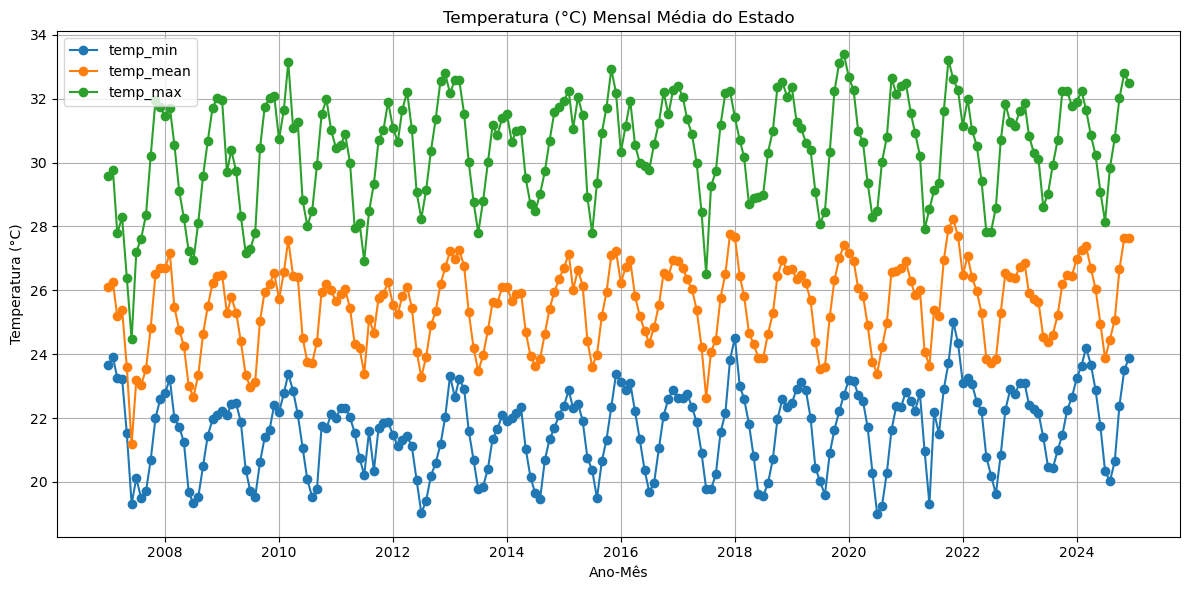

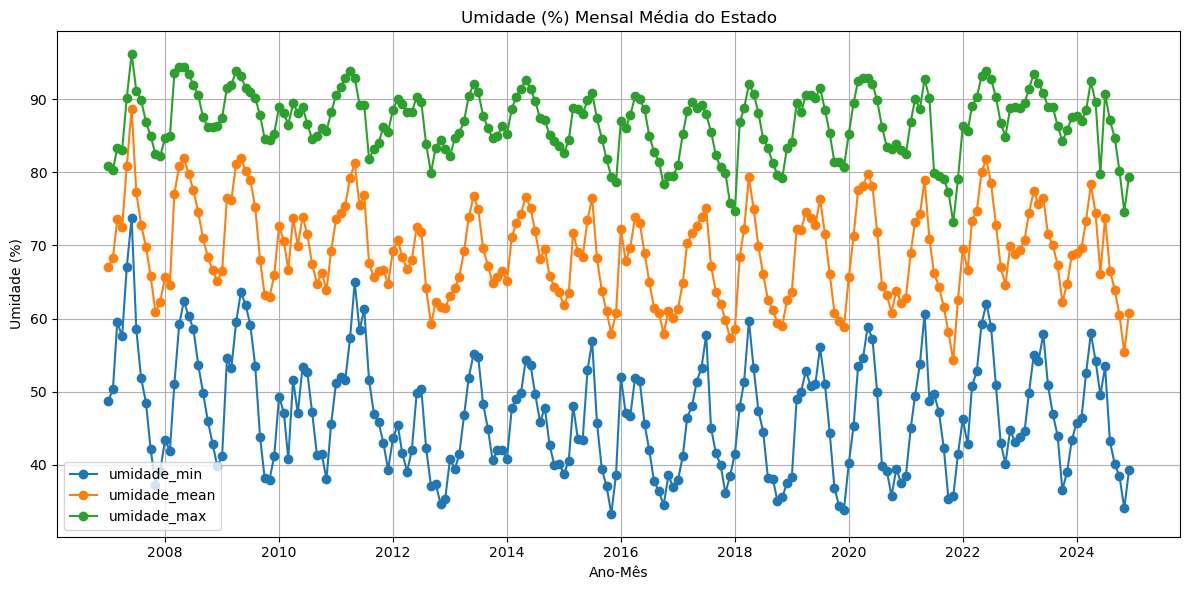

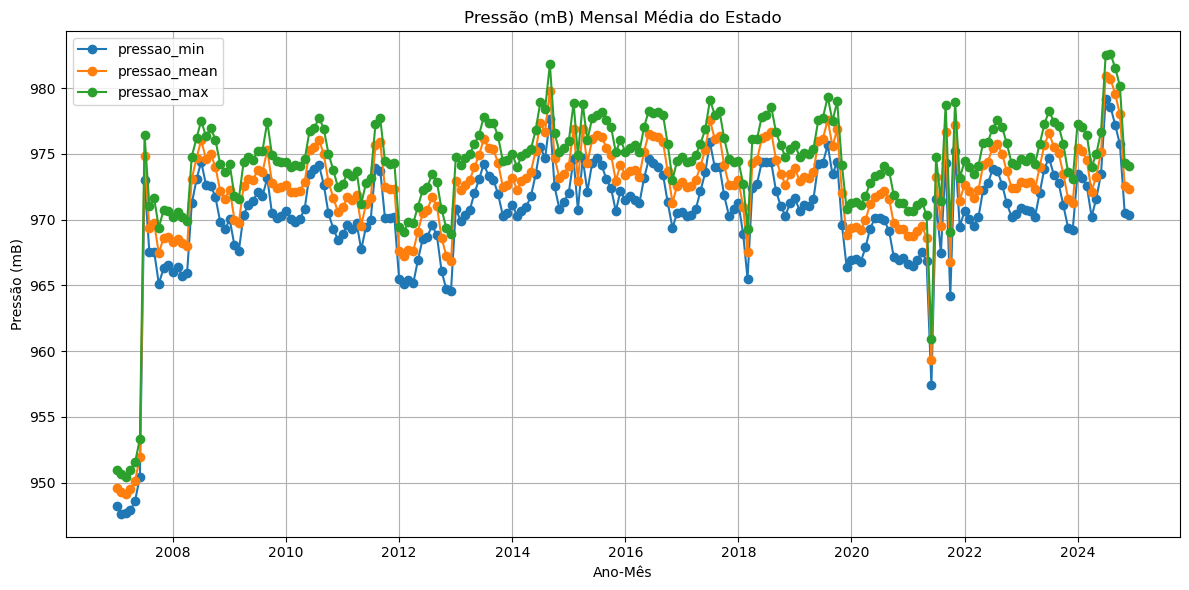

In [42]:
import matplotlib.pyplot as plt

variaveis = {
    'Temperatura (°C)': ['temp_min', 'temp_mean', 'temp_max'],
    'Umidade (%)': ['umidade_min', 'umidade_mean', 'umidade_max'],
    'Pressão (mB)': ['pressao_min', 'pressao_mean', 'pressao_max']
}

for nome, colunas in variaveis.items():
    plt.figure(figsize=(12,6))
    for col in colunas:
        plt.plot(media_mensal_estado['ano_mes'], media_mensal_estado[col], marker='o', label=col)
    
    plt.title(f'{nome} Mensal Média do Estado')
    plt.xlabel('Ano-Mês')
    plt.ylabel(nome)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
media_mensal_estado.to_csv('media_mensal_estado.csv', index=False, encoding='utf-8')


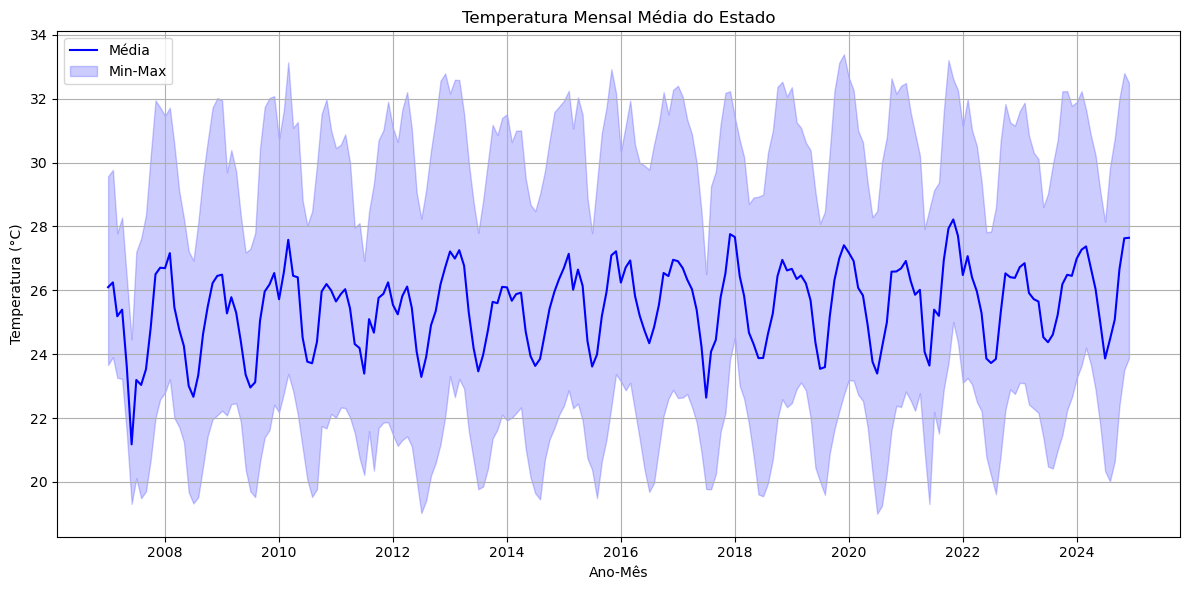

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot linha da média
plt.plot(media_mensal_estado['ano_mes'], media_mensal_estado['temp_mean'], color='blue', label='Média')

# Sombreia entre min e max
plt.fill_between(
    media_mensal_estado['ano_mes'],
    media_mensal_estado['temp_min'],
    media_mensal_estado['temp_max'],
    color='blue',
    alpha=0.2,
    label='Min-Max'
)

plt.title('Temperatura Mensal Média do Estado')
plt.xlabel('Ano-Mês')
plt.ylabel('Temperatura (°C)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


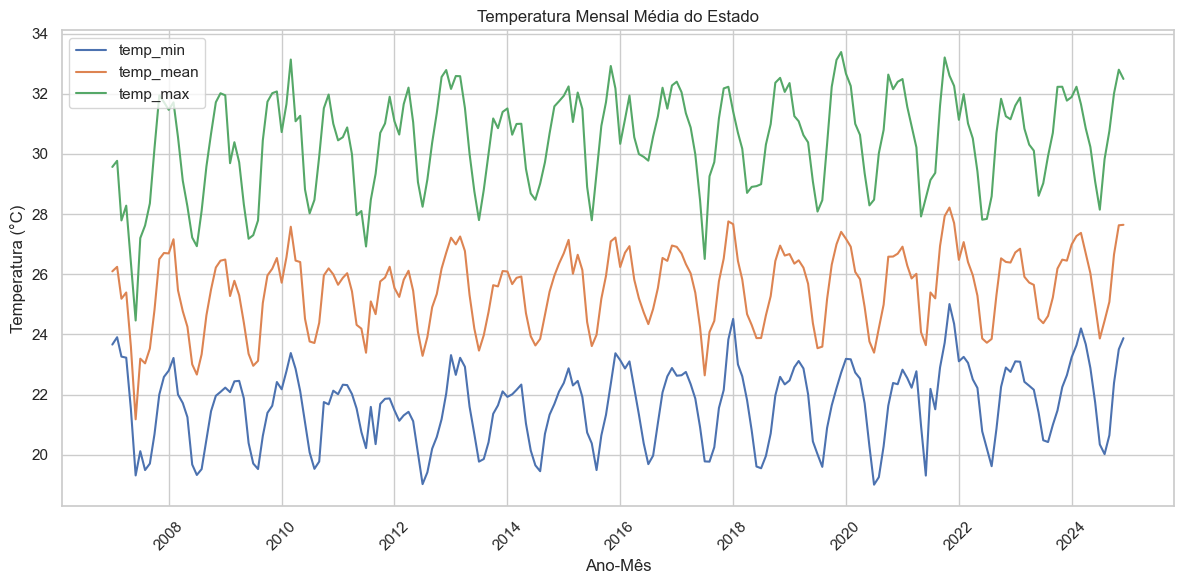

In [44]:
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(12,6))

for col in ['temp_min', 'temp_mean', 'temp_max']:
    sns.lineplot(x='ano_mes', y=col, data=media_mensal_estado, label=col)

plt.title('Temperatura Mensal Média do Estado')
plt.xlabel('Ano-Mês')
plt.ylabel('Temperatura (°C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


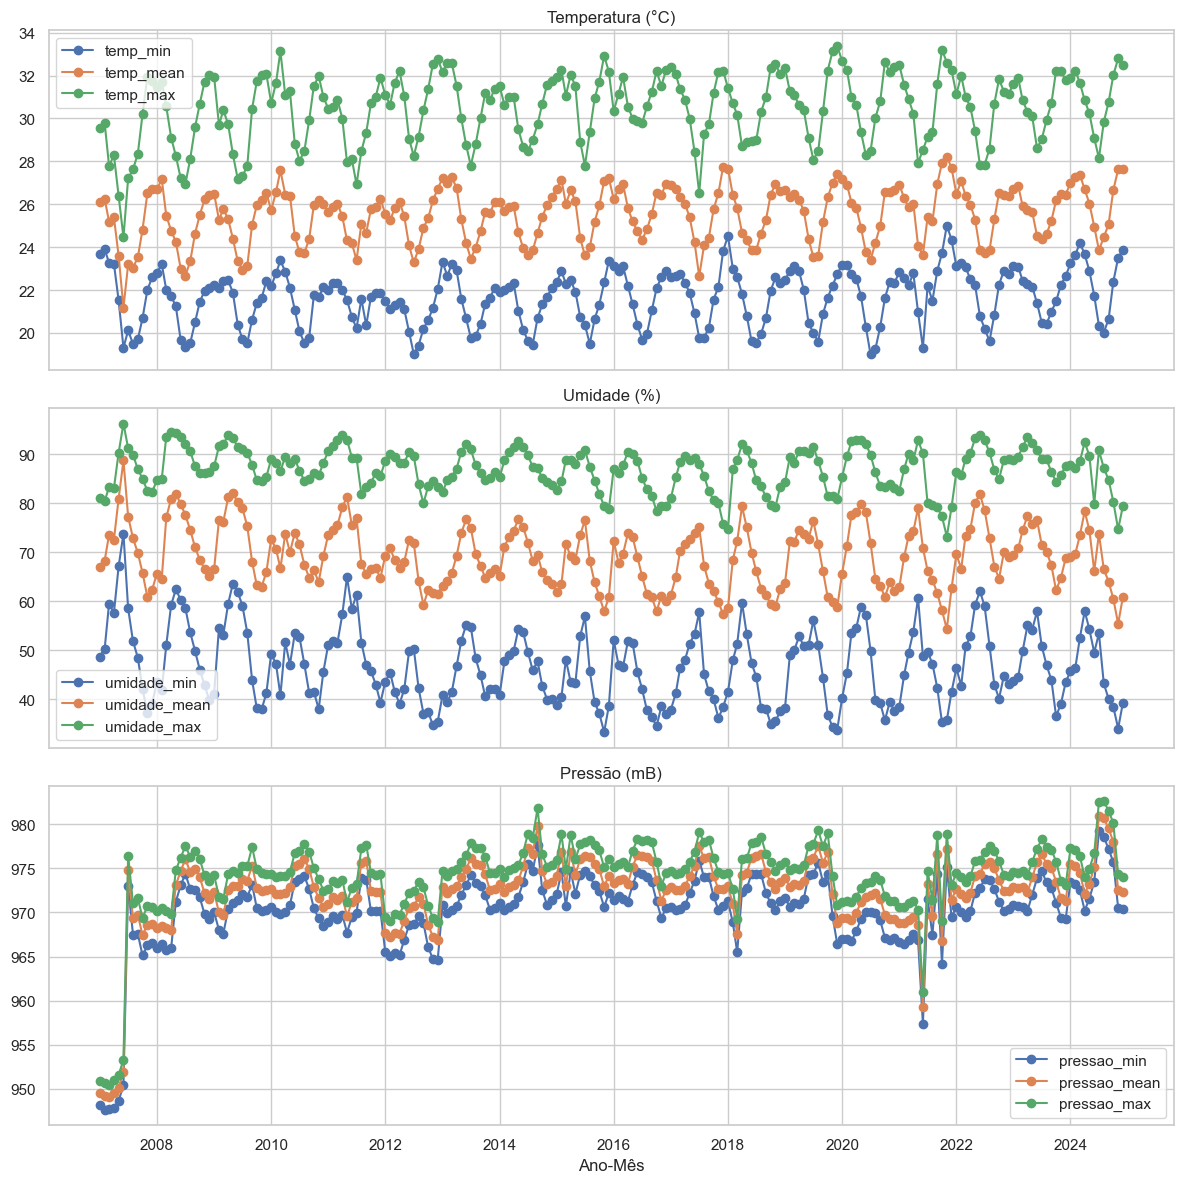

In [45]:
fig, axes = plt.subplots(3, 1, figsize=(12,12), sharex=True)

variaveis = {
    'Temperatura (°C)': ['temp_min', 'temp_mean', 'temp_max'],
    'Umidade (%)': ['umidade_min', 'umidade_mean', 'umidade_max'],
    'Pressão (mB)': ['pressao_min', 'pressao_mean', 'pressao_max']
}

for ax, (nome, colunas) in zip(axes, variaveis.items()):
    for col in colunas:
        ax.plot(media_mensal_estado['ano_mes'], media_mensal_estado[col], marker='o', label=col)
    ax.set_title(nome)
    ax.grid(True)
    ax.legend()

plt.xlabel('Ano-Mês')
plt.tight_layout()
plt.show()


# PyMan-Kendall

In [47]:
!pip install pymannkendall

In [48]:
import pymannkendall as mk
import pandas as pd

variaveis = ['temp_min', 'temp_max', 'temp_mean',
             'umidade_min', 'umidade_max', 'umidade_mean',
             'pressao_min', 'pressao_max', 'pressao_mean']

# Dicionário para armazenar resultados
tendencias = {}

for var in variaveis:
    resultados = {}
    
    # Original test
    res_orig = mk.original_test(media_mensal_estado[var])
    resultados['original_trend'] = res_orig.trend
    resultados['original_p'] = res_orig.p
    resultados['original_slope'] = res_orig.slope
    
    # Hamed-Rao modification
    res_hamed = mk.hamed_rao_modification_test(media_mensal_estado[var])
    resultados['hamed_trend'] = res_hamed.trend
    resultados['hamed_p'] = res_hamed.p
    resultados['hamed_slope'] = res_hamed.slope
    
    # Yue-Wang modification
    res_yue = mk.yue_wang_modification_test(media_mensal_estado[var])
    resultados['yue_trend'] = res_yue.trend
    resultados['yue_p'] = res_yue.p
    resultados['yue_slope'] = res_yue.slope
    
    tendencias[var] = resultados

# Transformar em DataFrame
tendencias_df = pd.DataFrame(tendencias).T
print(tendencias_df)


             original_trend original_p original_slope hamed_trend   hamed_p  \
temp_min         increasing    0.00197       0.004289  increasing   0.00037   
temp_max         increasing   0.000901       0.005621  increasing  0.004944   
temp_mean        increasing   0.000561       0.004805  increasing  0.000016   
umidade_min      decreasing   0.022162      -0.020041    no trend   0.07592   
umidade_max        no trend   0.133304      -0.007616    no trend  0.160791   
umidade_mean     decreasing   0.026306      -0.016722    no trend  0.076707   
pressao_min      increasing   0.000083       0.012694  increasing  0.029888   
pressao_max      increasing    0.00014       0.012487  increasing   0.03532   
pressao_mean     increasing   0.000116       0.012498  increasing  0.036287   

             hamed_slope   yue_trend     yue_p yue_slope  
temp_min        0.004289  increasing       0.0  0.004289  
temp_max        0.005621  increasing       0.0  0.005621  
temp_mean       0.004805  increa

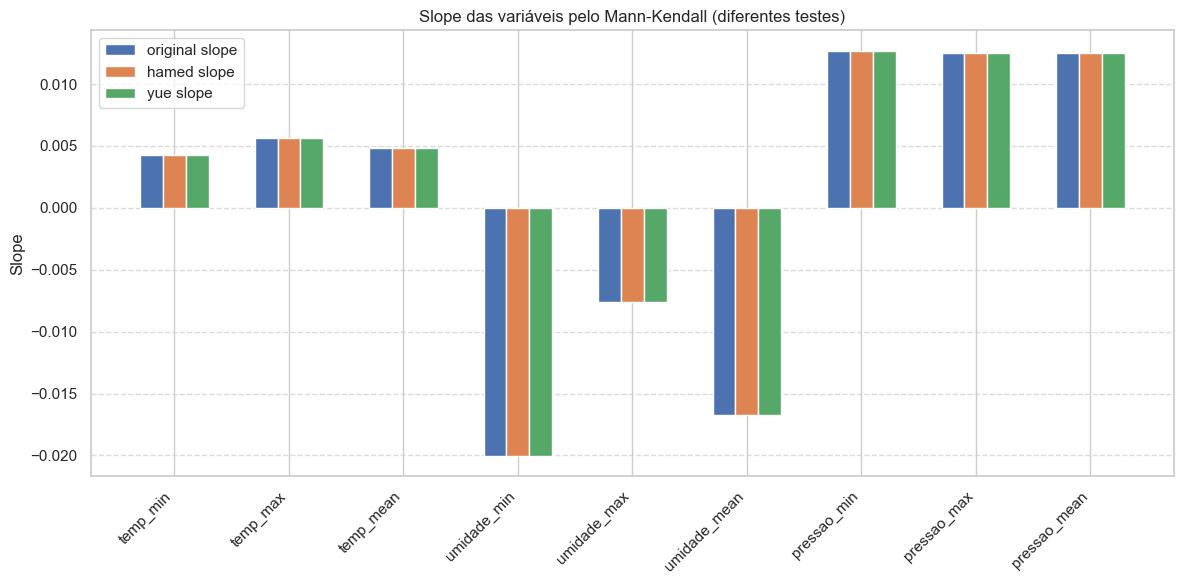

In [50]:
import matplotlib.pyplot as plt

# Separar testes
testes = ['original', 'hamed', 'yue']

# Configuração do gráfico
fig, ax = plt.subplots(figsize=(12,6))

largura = 0.2  # largura das barras
x = range(len(variaveis))

for i, teste in enumerate(testes):
    slopes = tendencias_df[f"{teste}_slope"]
    ax.bar([p + i*largura for p in x], slopes, width=largura, label=f"{teste} slope")

# Configurações do eixo x
ax.set_xticks([p + largura for p in x])
ax.set_xticklabels(variaveis, rotation=45, ha='right')

# Rótulos e título
ax.set_ylabel("Slope")
ax.set_title("Slope das variáveis pelo Mann-Kendall (diferentes testes)")
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


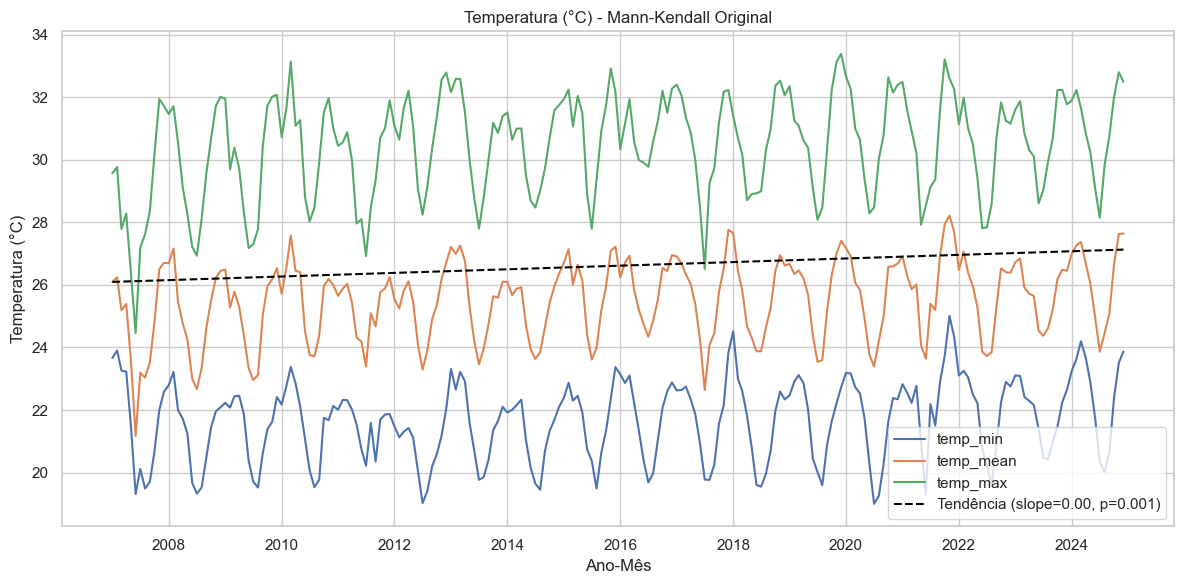

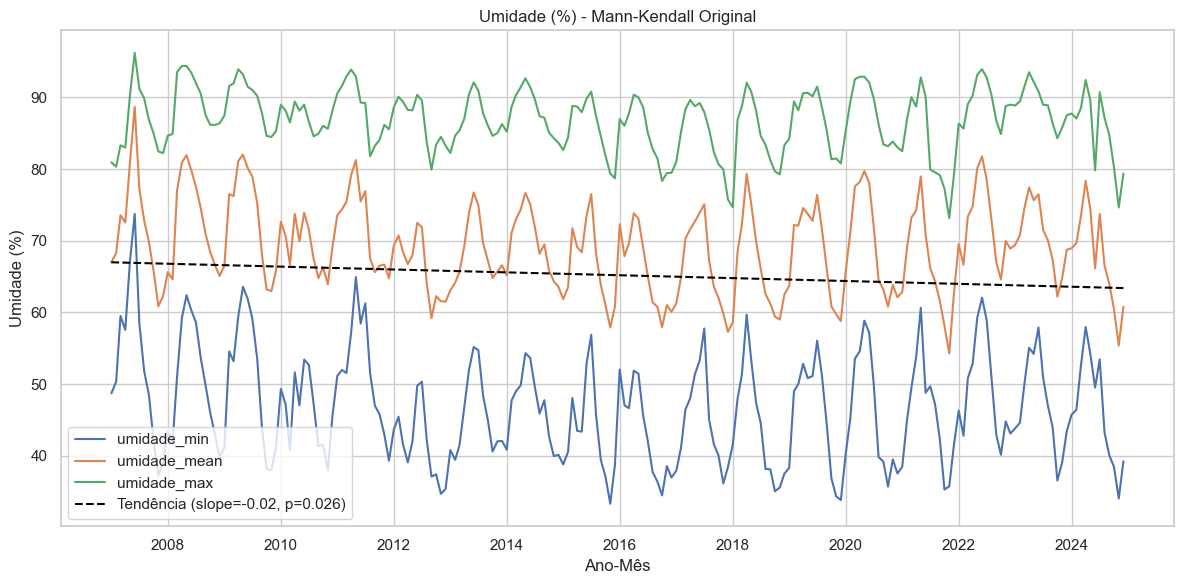

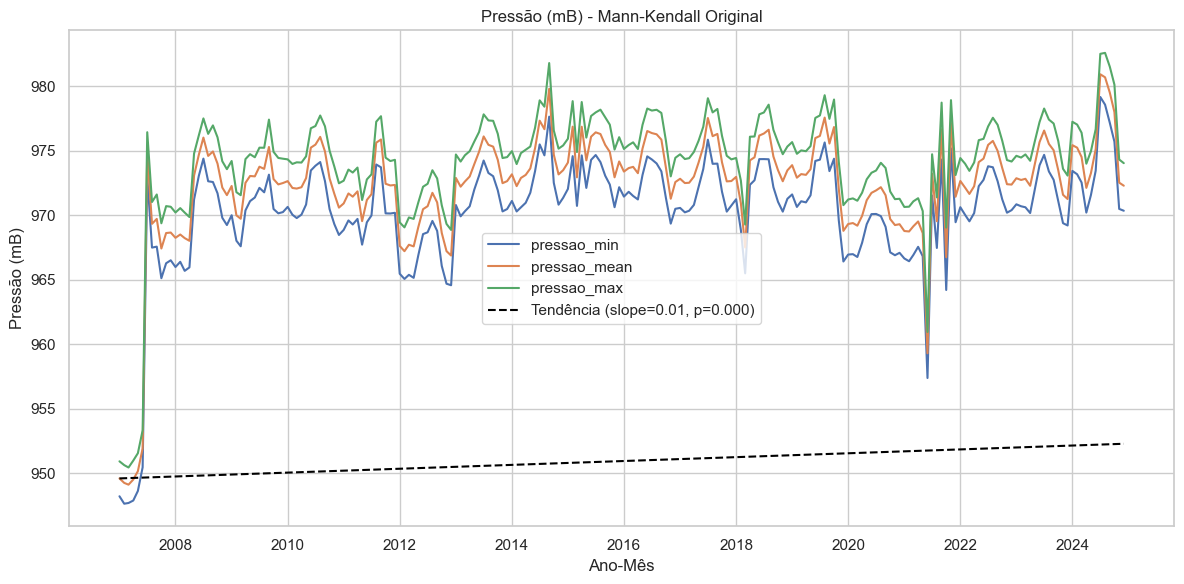

In [49]:
import matplotlib.pyplot as plt
import pymannkendall as mk

# Função para plotar uma variável com min, mean, max
def plot_variavel_trend(df, prefixo, titulo):
    colunas = [f"{prefixo}_min", f"{prefixo}_mean", f"{prefixo}_max"]
    
    plt.figure(figsize=(12, 6))
    
    for col in colunas:
        plt.plot(df['ano_mes'], df[col], label=col)
    
    # Calcula Mann-Kendall original para a média
    res = mk.original_test(df[f"{prefixo}_mean"])
    
    # Plota linha de tendência da média
    slope = res.slope
    intercept = df[f"{prefixo}_mean"].iloc[0] - slope * 0  # assume x=0 no primeiro ponto
    plt.plot(df['ano_mes'], df[f"{prefixo}_mean"].iloc[0] + slope * range(len(df)), 
             color='black', linestyle='--', label=f"Tendência (slope={slope:.2f}, p={res.p:.3f})")
    
    plt.title(f"{titulo} - Mann-Kendall Original")
    plt.xlabel("Ano-Mês")
    plt.ylabel(titulo)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Plotar cada variável
plot_variavel_trend(media_mensal_estado, 'temp', 'Temperatura (°C)')
plot_variavel_trend(media_mensal_estado, 'umidade', 'Umidade (%)')
plot_variavel_trend(media_mensal_estado, 'pressao', 'Pressão (mB)')


Sim! No matplotlib (e consequentemente no seaborn, que é baseado nele) você consegue salvar gráficos em PNG com resolução customizada usando o parâmetro dpi na função savefig().

🔹 Exemplo básico
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Exemplo de dados
data = pd.DataFrame({
    'cidade': ['Campina', 'Patos', 'Cabaceiras', 'Monteiro'],
    'temp_mean': [25.3, 26.1, 24.8, 25.7],
    'umidade_mean': [70, 65, 72, 68]
})

# Plot usando seaborn
plt.figure(figsize=(10,6))  # tamanho da figura em polegadas
sns.barplot(x='cidade', y='temp_mean', data=data)
plt.title("Temperatura média")

# Salvar em PNG
plt.savefig("temperatura_media.png", dpi=1080)  # dpi alto para alta resolução
plt.show()